In [1]:
import sys, os
sys.path.append(os.path.abspath(".."))

import numpy as np
from matplotlib.ticker import MaxNLocator
import matplotlib.pyplot as plt
import pandas as pd
from typing import Optional, Dict
# from dim_est.analysis.plotting_functions_infinite_data import *
from tqdm import tqdm
import matplotlib as mpl
from dim_est.datasets.data_generation import make_data_generator
from dim_est.run.run_dsib_single_experiment import merge_with_validation
from dim_est.config.dataset_defaults import DATASET_DEFAULTS 
from cca_zoo.linear import CCA
import copy

from tqdm import tqdm

from cca_mi_estimation import generate_CCA_mi_estimate
# Global defaults for entire notebook
mpl.rcParams.update({
    "figure.figsize": (5, 5),
    "figure.dpi": 150,
    "font.size": 14,
    "axes.labelsize": 16,
    "axes.titlesize": 16,
    "xtick.labelsize": 12,
    "ytick.labelsize": 12,
    "legend.fontsize": 12,
})

from dim_est.analysis.h5_to_dataframe_plotting_helpers import load_mi_summary
from plotting_functions import plot_from_df_agg_errorbar_mean_stderr, plot_mi_vs_kz_from_df

/users/pgulat4/.conda/envs/MI_estimation/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
def plot_mi_vs_kz_joint_gaussian_panel(ax, outfile, transform_mode= "linear", do_CCA: bool = True, CCA_n_samples: int = 10_000, CCA_kz_list = range(1,11), dataset_type = "joint_gaussian", ds_cfg={}, cca_cache = "cca_mi_estimates.h5", use_cache=True, write_to_cache = True):
    
    dataset_type = 'joint_gaussian'
    mi_bits = 2.0   
    latent_dim = 4
    
    
    sweep_tags = {
        "tags.dataset_type": [dataset_type],
        "tags.critic_type": ["hybrid", "separable", "separable_augmented"],
    }
    
    extra_filters = {
        "params.experiment_cfg.dataset.cfg.latent.latent_dim": latent_dim,
        "params.experiment_cfg.dataset.cfg.latent.mi_bits": mi_bits,
        "params.experiment_cfg.dataset.cfg.transform.mode": transform_mode,
        "tags.estimator": "lclip",
    }
    
    results_df = load_mi_summary(
        outfile=outfile,
        sweep_tags=sweep_tags,
        extra_filters=extra_filters,
        setup = "infinite_data_iter",
        metric_keys="mi_bits",         
        include_meta_keys=[
            "tags.kz",
        ]
    )

    Nx = ds_cfg["transform"]["observe_dim_x"]
    
    title = rf"{dataset_type}, $F^{{\mathrm{{{transform_mode}}}}} \rightarrow \mathbb{{R}}^{{{Nx}}} $"
    
    def label_fn(group_vals):
            critic_type, = group_vals ## group_vals is always a tuple (read with the comma)
            return rf"{critic_type}"
    
    plot_mi_vs_kz_from_df(
        ax,
        results_df,
        group_keys=["critic_type"],
        x_key="kz",
        y_key="max_smoothed_info",
        yerr_key="std_smoothed_info",
        label_fn=label_fn,
        title=title,
        true_dim=latent_dim
    )

    if do_CCA:
        mi_list = []

        data_generator = make_data_generator(dataset_type, ds_cfg, device="cpu")
        
        for kz in tqdm(CCA_kz_list, desc= "generating CCA estimates (or loading from cache)"):
            mi_kz = generate_CCA_mi_estimate(data_generator, ds_cfg, CCA_n_samples, kz, cache_path = cca_cache, use_cache=use_cache, write_to_cache = write_to_cache)
            mi_list.append(mi_kz)
        
        ax.plot(CCA_kz_list, mi_list, label = r'CCA', c='r')
        ax.scatter(CCA_kz_list, mi_list, c='r')
        ax.legend()
        

        
        

In [4]:
def plot_mi_vs_kz_gaussian_mixture_panel(ax, outfile, transform_mode= "linear", do_CCA: bool = True, CCA_n_samples: int = 10_000, CCA_kz_list = range(1,11), dataset_type = "gaussian_mixture", ds_cfg={}, cca_cache = "cca_mi_estimates.h5", use_cache=True, write_to_cache = True):
    dataset_type = 'gaussian_mixture'
    n_peaks = 8 
    mu = 2.0
    mi_bits_peak = 2.0
    
    
    sweep_tags = {
        "tags.dataset_type": [dataset_type],
        "tags.critic_type": ["hybrid", "separable", "separable_augmented"],
    }
    
    extra_filters = {
        # "tags.n_iter": n_iter,
        "params.experiment_cfg.dataset.cfg.latent.n_peaks": n_peaks,
        "params.experiment_cfg.dataset.cfg.latent.mu": mu,
        "params.experiment_cfg.dataset.cfg.latent.mi_bits_peak": mi_bits_peak,
        "params.experiment_cfg.dataset.cfg.transform.mode": transform_mode,
        "tags.estimator": "lclip",
    }
    
    results_df = load_mi_summary(
        outfile=outfile,
        sweep_tags=sweep_tags,
        extra_filters=extra_filters,
        setup = "infinite_data_iter",
        metric_keys="mi_bits",         
        include_meta_keys=[
            "tags.kz",
        ]
    )
    
    Nx = ds_cfg["transform"]["observe_dim_x"]
    title = rf"{dataset_type}, $F^{{\mathrm{{{transform_mode}}}}} \rightarrow \mathbb{{R}}^{{{Nx}}} $"
    
    def label_fn(group_vals):
            critic_type, = group_vals ## group_vals is always a tuple (read with the comma)
            return rf"{critic_type}"
    
    plot_mi_vs_kz_from_df(
        ax,
        results_df,
        group_keys=["critic_type"],
        x_key="kz",
        y_key="max_smoothed_info",
        yerr_key="std_smoothed_info",
        label_fn=label_fn,
        title=title,
        true_dim=1
    )


    if do_CCA:
        mi_list = []
        data_generator = make_data_generator(dataset_type, ds_cfg, device="cpu")        
        for kz in tqdm(CCA_kz_list, desc= "generating CCA estimates (or loading from cache)"):
            mi_kz = generate_CCA_mi_estimate(data_generator, ds_cfg, CCA_n_samples, kz, cache_path = cca_cache, use_cache=use_cache, write_to_cache = write_to_cache)
            mi_list.append(mi_kz)
        
        ax.plot(CCA_kz_list, mi_list, label = r'CCA', c='r')
        ax.scatter(CCA_kz_list, mi_list, c='r')
        ax.legend()
        

    
    

In [5]:
def plot_mi_vs_kz_joint_gaussian_panel_different_noise(ax, outfile, transform_mode= "teacher"):
    
    dataset_type = 'joint_gaussian'
    mi_bits = 2.0   
    latent_dim = 4
    Nx = 500
    Ny = 500
    
    
    sweep_tags = {
        "tags.dataset_type": [dataset_type],
        "tags.critic_type": ["hybrid"],
        "params.experiment_cfg.dataset.cfg.transform.sig_embed_x": [0.0, 0.5, 1.0, 2.0], ## same noise was added to x and y, add a check if necessary
    }
    
    extra_filters = {
        "params.experiment_cfg.dataset.cfg.latent.latent_dim": latent_dim,
        "params.experiment_cfg.dataset.cfg.latent.mi_bits": mi_bits,
        "params.experiment_cfg.dataset.cfg.transform.mode": transform_mode,
        "params.experiment_cfg.dataset.cfg.transform.observe_dim_x": Nx,
        "params.experiment_cfg.dataset.cfg.transform.observe_dim_x": Ny,
        "tags.estimator": "lclip",
    }
    
    results_df = load_mi_summary(
        outfile=outfile,
        sweep_tags=sweep_tags,
        extra_filters=extra_filters,
        setup = "infinite_data_iter",
        metric_keys="mi_bits",         
        include_meta_keys=[
            "tags.kz",
        ]
    )

    
    title = rf"{dataset_type}, $F^{{\mathrm{{{transform_mode}}}}} \rightarrow \mathbb{{R}}^{{{Nx}}} $"
    
    def label_fn(group_vals):
        critic_type, sig_embed_x = group_vals ## group_vals is always a tuple (read with the comma)
        return rf"$\eta = $ {sig_embed_x}"

    
    plot_mi_vs_kz_from_df(
        ax,
        results_df,
        group_keys=["critic_type", "experiment_cfg.dataset.cfg.transform.sig_embed_x"],
        x_key="kz",
        y_key="max_smoothed_info",
        yerr_key="std_smoothed_info",
        label_fn=label_fn,
        title=title,
        true_dim=latent_dim
    )


In [6]:
def plot_mi_vs_kz_gaussian_mixture_panel_different_noise(ax, outfile, transform_mode= "teacher"):
    dataset_type = 'gaussian_mixture'
    n_peaks = 8 
    mu = 2.0
    mi_bits_peak = 2.0
    Nx = 500
    Ny = 500
        
    
    sweep_tags = {
        "tags.dataset_type": [dataset_type],
        "tags.critic_type": ["hybrid"],
        "params.experiment_cfg.dataset.cfg.transform.sig_embed_x": [0.0, 0.5, 1.0, 2.0], ## same noise was added to x and y, add a check if necessary
    }
    
    extra_filters = {
        # "tags.n_iter": n_iter,
        "params.experiment_cfg.dataset.cfg.latent.n_peaks": n_peaks,
        "params.experiment_cfg.dataset.cfg.latent.mu": mu,
        "params.experiment_cfg.dataset.cfg.latent.mi_bits_peak": mi_bits_peak,
        "params.experiment_cfg.dataset.cfg.transform.mode": transform_mode,
        "params.experiment_cfg.dataset.cfg.transform.observe_dim_x": Nx,
        "params.experiment_cfg.dataset.cfg.transform.observe_dim_x": Ny,
        "tags.estimator": "lclip",
    }
    
    results_df = load_mi_summary(
        outfile=outfile,
        sweep_tags=sweep_tags,
        extra_filters=extra_filters,
        setup = "infinite_data_iter",
        metric_keys="mi_bits",         
        include_meta_keys=[
            "tags.kz",
        ]
    )
    
    title = rf"{dataset_type}, $F^{{\mathrm{{{transform_mode}}}}} \rightarrow \mathbb{{R}}^{{{Nx}}} $"
    
    def label_fn(group_vals):
        critic_type, sig_embed_x = group_vals ## group_vals is always a tuple (read with the comma)
        return rf"$\eta = $ {sig_embed_x}"

    plot_mi_vs_kz_from_df(
        ax,
        results_df,
        group_keys=["critic_type", "experiment_cfg.dataset.cfg.transform.sig_embed_x"],
        x_key="kz",
        y_key="max_smoothed_info",
        yerr_key="std_smoothed_info",
        label_fn=label_fn,
        title=title,
        true_dim=1
    )     

    
    

In [7]:
def plot_mi_vs_kz_hypershell_panel_different_noise(ax, outfile, transform_mode= "teacher"):

    # outfile = "h5_results/infinite_data_hyperspherical_shell_teacher_transform_noisy.h5"
    radial_std = 0.5 ## 2.0, or 0.5 results on the cluster
    latent_dim  = 3 
    Nx = 500
    Ny = 500
    
    
    dataset_type = 'hyperspherical_shell'
    # n_iter=20_000
    
    sweep_tags = {
        "tags.dataset_type": [dataset_type],
        "tags.critic_type": ["hybrid"],
        "params.experiment_cfg.dataset.cfg.transform.sig_embed_x": [0.5, 1.0, 2.0, 4.0],
    }
    
    extra_filters = {
        "params.experiment_cfg.dataset.cfg.latent.latent_dim": latent_dim,
        "params.experiment_cfg.dataset.cfg.latent.radial_std": radial_std,
        "params.experiment_cfg.dataset.cfg.transform.mode": transform_mode,
        "params.experiment_cfg.dataset.cfg.transform.observe_dim_x": Nx,
        "params.experiment_cfg.dataset.cfg.transform.observe_dim_x": Ny,
        "tags.estimator": "lclip",
    }
    
    results_df = load_mi_summary(
        outfile=outfile,
        sweep_tags=sweep_tags,
        extra_filters=extra_filters,
        setup = "infinite_data_iter",
        metric_keys="mi_bits",         
        include_meta_keys=[
            "tags.kz",
        ]
    )
    
    
    def label_fn(group_vals):
        critic_type, sig_embed = group_vals
        return rf"$\eta = {sig_embed}$"
    
    title = rf'{dataset_type}: $K_Z = $ {latent_dim}, $\sigma_r = $ {radial_std} '
    
    plot_mi_vs_kz_from_df(
        ax,
        results_df,
        group_keys=("critic_type", "experiment_cfg.dataset.cfg.transform.sig_embed_x"),
        x_key="kz",
        y_key="max_smoothed_info",
        yerr_key="std_smoothed_info",
        label_fn=label_fn,
        title=title,
        true_dim=latent_dim,
    )

In [8]:
def plot_mi_vs_kz_swissroll_panel_different_noise(ax, outfile, transform_mode= "teacher"):
    
    dataset_type = 'swiss_roll'
    # outfile = "h5_results/infinite_data_swiss_roll_teacher_transform_noisy.h5"
    latent_dim =3
    t_min = 1.5
    t_max = 3.5
    Nx = 500
    Ny = 500
    # n_iter=20_000
    
        
    sweep_tags = {
        "tags.dataset_type": [dataset_type],
        "tags.critic_type": ["hybrid"],
        "params.experiment_cfg.dataset.cfg.transform.sig_embed_x": [0.5, 1.0, 2.0, 4.0], ## same noise was added to x and y, add a check if necessary
    }
        
    extra_filters = {
        "params.experiment_cfg.dataset.cfg.latent.latent_dim": latent_dim,
        "params.experiment_cfg.dataset.cfg.latent.t_min_pi_units": t_min,
        "params.experiment_cfg.dataset.cfg.latent.t_max_pi_units": t_max,
        "params.experiment_cfg.dataset.cfg.transform.mode": transform_mode,
        "params.experiment_cfg.dataset.cfg.transform.observe_dim_x": Nx,
        "params.experiment_cfg.dataset.cfg.transform.observe_dim_x": Ny,
        #     # "tags.n_iter": n_iter,
        "tags.estimator": "lclip",
    }
    
    results_df = load_mi_summary(
        outfile=outfile,
        sweep_tags=sweep_tags,
        extra_filters=extra_filters,
        setup = "infinite_data_iter",
        metric_keys="mi_bits",         
        include_meta_keys=[
            "tags.kz",
        ]
    )
    
    
    def label_fn(group_vals):
        critic_type, sig_embed = group_vals
        return rf"$\eta = {sig_embed}$"
    
    title = rf"{dataset_type}, $t \in [{t_min}\pi, {t_max}\pi]$"
    
    plot_mi_vs_kz_from_df(
        ax,
        results_df,
        group_keys=("critic_type", "experiment_cfg.dataset.cfg.transform.sig_embed_x"),
        x_key="kz",
        y_key="max_smoothed_info",
        yerr_key="std_smoothed_info",
        label_fn=label_fn,
        title=title,
        true_dim=2,   # actual latent dim of swiss-roll parameter space
    )
        

generating CCA estimates (or loading from cache): 100%|██████████| 14/14 [00:00<00:00, 197.29it/s]


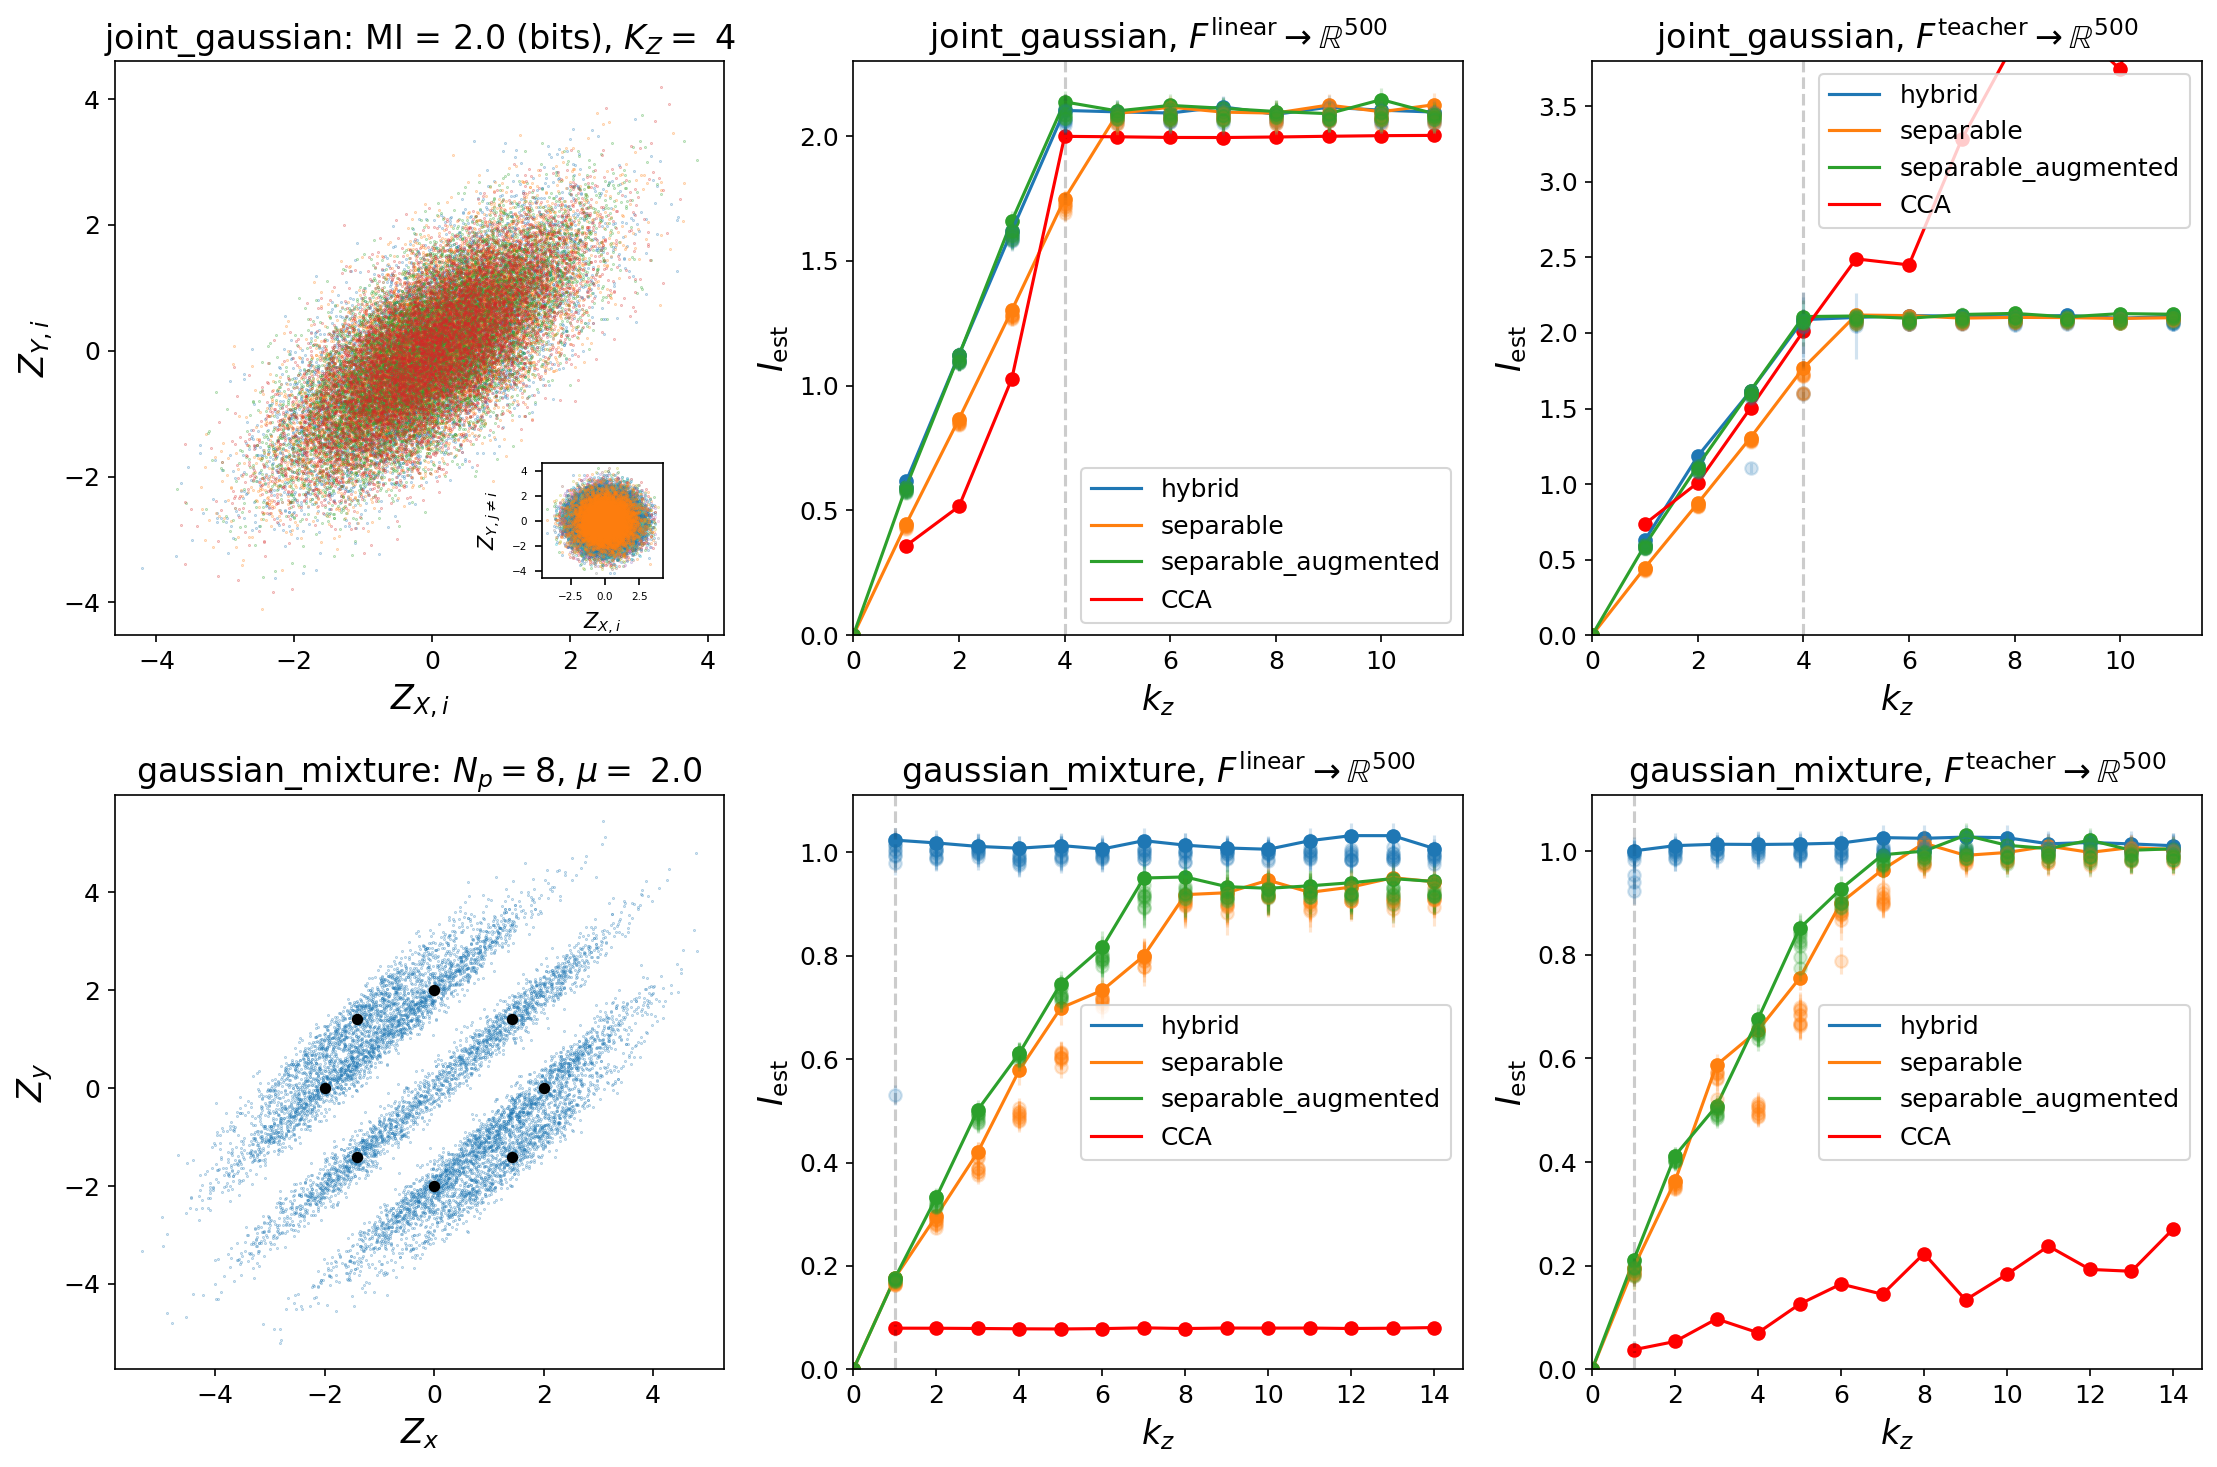

In [9]:
cca_cache =  "../cca_mi_estimates.h5"
fig, axes = plt.subplots(2,3, figsize=(15,10))

dataset_type = "joint_gaussian"

ax = axes[0,0]

latent_dim = 4
mi_bits = 2.0
dataset_overrides = dict(latent=dict(latent_dim=latent_dim, mi_bits=mi_bits), transform = dict(mode='identity', observe_dim_x =None, observe_dim_y =None))

ds_defaults = copy.deepcopy(DATASET_DEFAULTS[dataset_type])
ds_cfg = merge_with_validation(ds_defaults, dataset_overrides, "dataset overrides")
data_generator = make_data_generator(dataset_type, ds_cfg, device = 'cpu')
zx, zy = data_generator(10000)
for i in range(latent_dim):
    ax.scatter(zx[:, i], zy[:, i], alpha=0.5, s=0.1)# c= '#1f77b4'
    
ax.set_xlabel(r"$Z_{X, i}$")
ax.set_ylabel(r"$Z_{Y, i}$")

axin = ax.inset_axes([0.7, 0.1, 0.2, 0.2], transform =ax.transAxes)
for i in range(latent_dim):
    for j in range(latent_dim):
        if i!=j:
            axin.scatter(zx[:, i], zy[:, j], alpha=0.5, s=0.1)
    
axin.set_xlabel(r"$Z_{X, i}$", fontsize=10)
axin.set_ylabel(r"$Z_{Y, j\ne i}$", fontsize=10)
axin.tick_params(axis='both', which='major', labelsize=5)
ax.set_title(rf'{dataset_type}: MI = {mi_bits} (bits), $K_Z = $ {latent_dim}')


ax = axes[0, 1]
transform_mode = "linear"
outfile = "../h5_results/infinite_data_joint_gaussian_linear_transform.h5"
dataset_overrides = dict(latent=dict(latent_dim=latent_dim, mi_bits=mi_bits), transform = dict(mode=transform_mode, observe_dim_x =500, observe_dim_y =500))
ds_cfg = merge_with_validation(ds_defaults, dataset_overrides, "dataset overrides")
plot_mi_vs_kz_joint_gaussian_panel(ax, outfile, transform_mode= transform_mode, do_CCA = True, CCA_n_samples = 300_000, CCA_kz_list = range(1,12), dataset_type = dataset_type, ds_cfg=ds_cfg, cca_cache = cca_cache)
ax.set_ylim(bottom=0)
ax.set_xlim(left=0)

ax = axes[0, 2]
transform_mode = "teacher"
outfile = "../h5_results/infinite_data_joint_gaussian_teacher_transform.h5"
dataset_overrides = dict(latent=dict(latent_dim=latent_dim, mi_bits=mi_bits), transform = dict(mode=transform_mode, observe_dim_x =500, observe_dim_y =500))
ds_cfg = merge_with_validation(ds_defaults, dataset_overrides, "dataset overrides")
plot_mi_vs_kz_joint_gaussian_panel(ax, outfile, transform_mode= transform_mode, do_CCA = True, CCA_n_samples = 300_000, CCA_kz_list = range(1,12), dataset_type = dataset_type, ds_cfg=ds_cfg, cca_cache = cca_cache)
ax.set_ylim(top=3.8)
ax.set_ylim(bottom=0)
ax.set_xlim(left=0)
# ##############################################
ax = axes[1,0]

dataset_type = "gaussian_mixture"
n_peaks = 8 
mu =2.0
mi_bits_peak = 2.0
dataset_overrides = dict(latent=dict(n_peaks=n_peaks, mi_bits_peak=mi_bits_peak, mu= mu, sig=1.0), transform = dict(mode='identity', observe_dim_x =None, observe_dim_y =None))
ds_defaults = copy.deepcopy(DATASET_DEFAULTS[dataset_type])
ds_cfg = merge_with_validation(ds_defaults, dataset_overrides, "dataset overrides")
data_generator = make_data_generator(dataset_type, ds_cfg, device = 'cpu')

zx, zy = data_generator(10000)

ax.scatter(zx, zy, alpha=0.5, s=0.1)
ax.set_xlabel(r"$Z_x$")
ax.set_ylabel(r"$Z_y$")
ax.set_title(rf'{dataset_type}: $N_p = ${n_peaks}, $\mu = $ {mu}')
####overlay centers:
theta = np.linspace(0, 2*np.pi, n_peaks, endpoint=False)
centers_x = mu * np.cos(theta)
centers_y = mu * np.sin(theta)
# overlay the cluster centers
ax.scatter(centers_x, centers_y, s=20, c='black', marker='o')


ax = axes[1, 1]
transform_mode = "linear"
outfile = "../h5_results/infinite_data_gaussian_mixture_linear_transform.h5"
dataset_overrides = dict(latent=dict(n_peaks=n_peaks, mi_bits_peak=mi_bits_peak, mu= mu, sig=1.0), transform = dict(mode='linear', observe_dim_x = 500, observe_dim_y = 500))
ds_cfg = merge_with_validation(ds_defaults, dataset_overrides, "dataset overrides")
plot_mi_vs_kz_gaussian_mixture_panel(ax, outfile, transform_mode= transform_mode, do_CCA = True, CCA_n_samples = 300_000, CCA_kz_list = range(1,15), dataset_type = dataset_type, ds_cfg=ds_cfg, cca_cache = cca_cache)
ax.set_ylim(bottom=0)
ax.set_xlim(left=0)

ax = axes[1, 2]
transform_mode = "teacher"
outfile = "../h5_results/infinite_data_gaussian_mixture_teacher_transform.h5"
dataset_overrides = dict(latent=dict(n_peaks=n_peaks, mi_bits_peak=mi_bits_peak, mu= mu, sig=1.0), transform = dict(mode='teacher', observe_dim_x = 500, observe_dim_y = 500))
ds_cfg = merge_with_validation(ds_defaults, dataset_overrides, "dataset overrides")
plot_mi_vs_kz_gaussian_mixture_panel(ax, outfile, transform_mode= transform_mode, do_CCA = True, CCA_n_samples = 300_000, CCA_kz_list = range(1,15), dataset_type = dataset_type, ds_cfg=ds_cfg, cca_cache =cca_cache)
ax.set_ylim(bottom=0)
ax.set_xlim(left=0)

# ##############################################

plt.tight_layout()
plt.show()

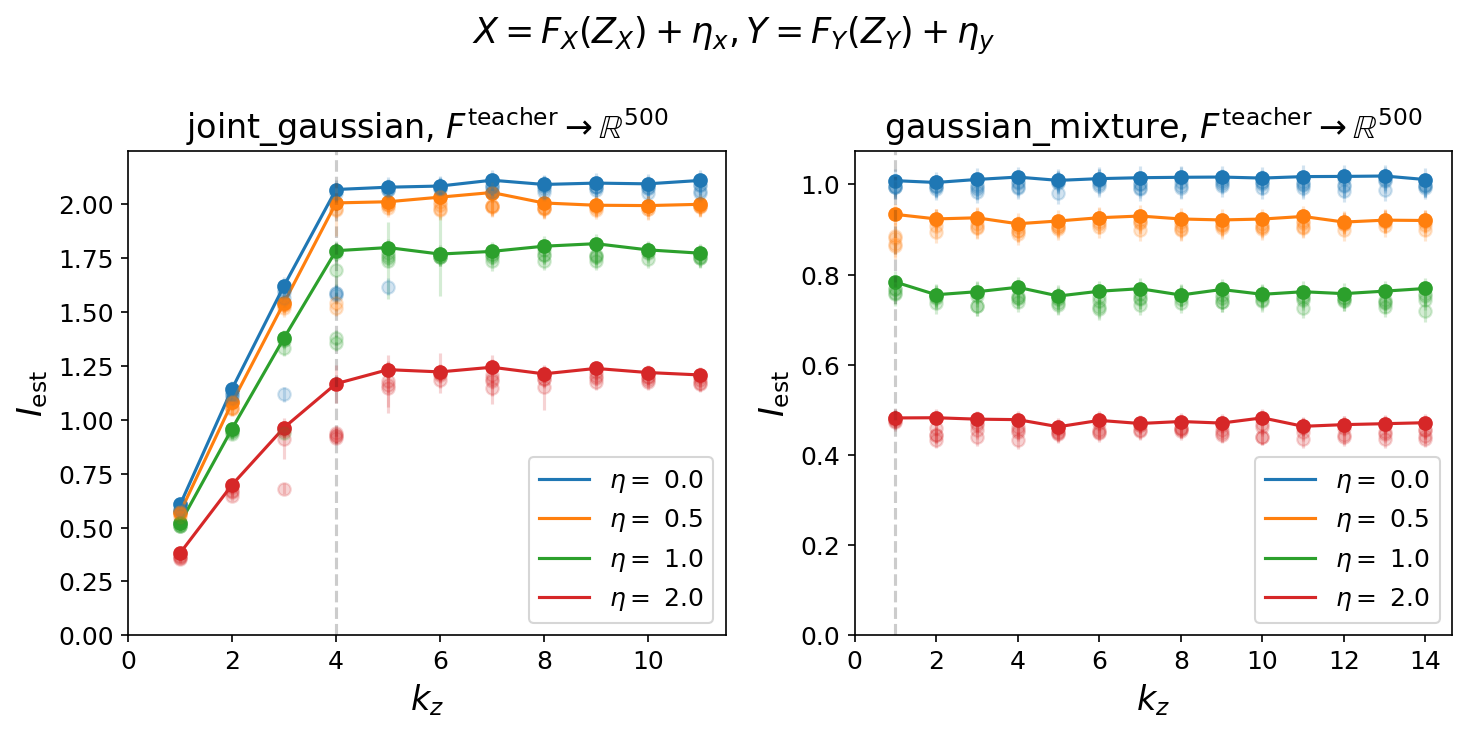

In [10]:
fig, axes = plt.subplots(1,2, figsize=(10,5))

dataset_type = "joint_gaussian"

ax =axes[0]
outfile = "../h5_results/infinite_data_joint_gaussian_teacher_transform_noisy.h5"
plot_mi_vs_kz_joint_gaussian_panel_different_noise(ax, outfile)
ax.set_ylim(bottom=0)
ax.set_xlim(left=0)

ax =axes[1]
outfile = "../h5_results/infinite_data_gaussian_mixture_teacher_transform_noisy.h5"
plot_mi_vs_kz_gaussian_mixture_panel_different_noise(ax, outfile)
ax.set_ylim(bottom=0)
ax.set_xlim(left=0)

fig.suptitle(r'$X = F_X(Z_X) + \eta_x, Y = F_Y(Z_Y) + \eta_y$')
plt.tight_layout()
plt.show()

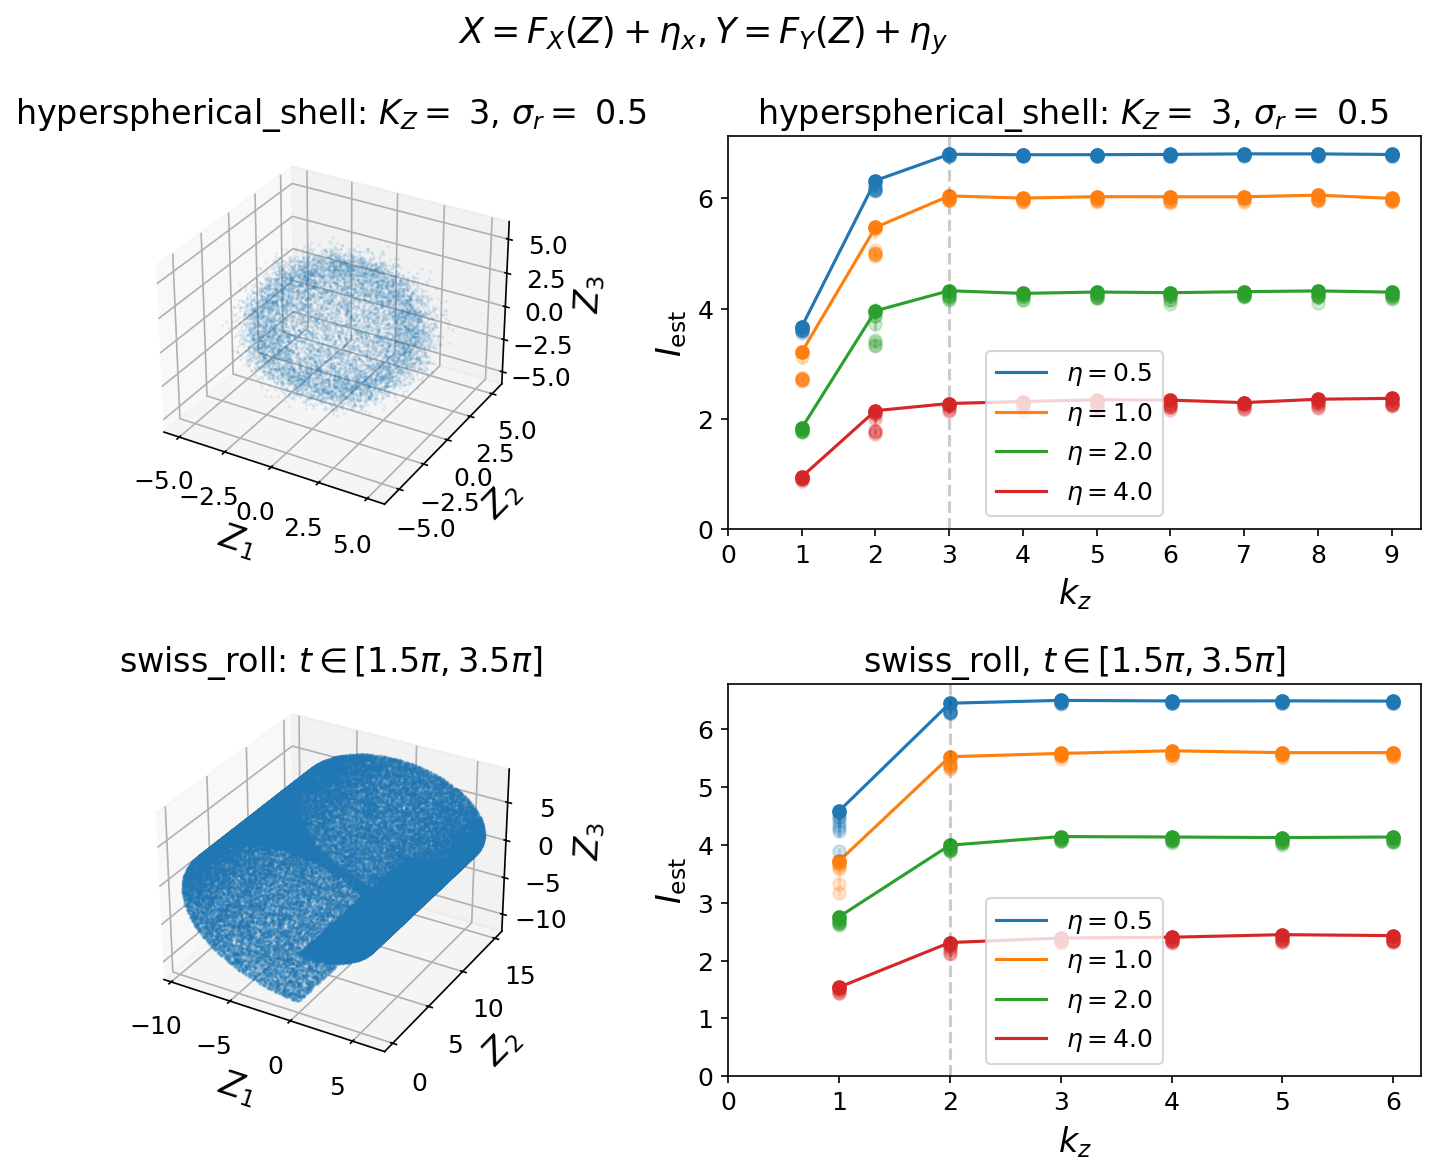

In [11]:
from mpl_toolkits.mplot3d import Axes3D  # needed for 3D projection
fig = plt.figure(figsize=(10, 8))

# Panel 1: 3D subplot
ax = fig.add_subplot(2, 2, 1, projection="3d")

dataset_type = "hyperspherical_shell"

latent_dim=3
radial_std = 0.5
dataset_overrides = dict(latent=dict(latent_dim=latent_dim, radial_std=radial_std), transform = dict(mode='identity', observe_dim_x =None, observe_dim_y =None))
ds_defaults = copy.deepcopy(DATASET_DEFAULTS[dataset_type])
ds_cfg = merge_with_validation(ds_defaults, dataset_overrides, "dataset overrides")
data_generator = make_data_generator(dataset_type, ds_cfg, device = 'cpu')

zx, zy = data_generator(10000)
z_np = zx
x, y, z = z_np[:, 0], z_np[:, 1], z_np[:, 2]

# ax = fig.add_subplot(111, projection='3d')
ax.scatter(x, y, z, s=0.3, alpha=0.1)
ax.set_xlabel(r"$Z_1$")
ax.set_ylabel(r"$Z_2$")
ax.set_zlabel(r"$Z_3$")
ax.set_title(rf'{dataset_type}: $K_Z =$ {latent_dim}, $\sigma_r = $ {radial_std}')

##########################################################
##########################################################
ax2 = fig.add_subplot(2, 2, 2)
outfile = "../h5_results/infinite_data_hyperspherical_shell_teacher_transform_noisy.h5"
plot_mi_vs_kz_hypershell_panel_different_noise(ax2, outfile)

ax2.set_ylim(bottom=0)
ax2.set_xlim(left=0)
##########################################################
##########################################################
ax = fig.add_subplot(2, 2, 3, projection="3d")

dataset_type = "swiss_roll"
t_min = 1.5 # kept fixed in the sims
t_max = 3.5
dataset_overrides = dict(latent=dict(t_min_pi_units=t_min, t_max_pi_units=t_max), transform = dict(mode='identity', observe_dim_x =None, observe_dim_y =None))
ds_defaults = copy.deepcopy(DATASET_DEFAULTS[dataset_type])
ds_cfg = merge_with_validation(ds_defaults, dataset_overrides, "dataset overrides")
data_generator = make_data_generator(dataset_type, ds_cfg, device = 'cpu')

zx, zy = data_generator(100000)

z_np = zx
x, y, t = z_np[:, 0], z_np[:, 1], z_np[:, 2]

ax.scatter(x, y, t, s=0.3, alpha=0.2)
ax.set_xlabel(r"$Z_1$")
ax.set_ylabel(r"$Z_2$")
ax.set_zlabel(r"$Z_3$")
ax.set_title( rf"{dataset_type}: $t \in [{t_min}\pi, {t_max}\pi]$")

##########################################################
##########################################################
ax4 = fig.add_subplot(2, 2, 4)
outfile = "../h5_results/infinite_data_swiss_roll_teacher_transform_noisy.h5"
plot_mi_vs_kz_swissroll_panel_different_noise(ax4, outfile)


ax4.set_ylim(bottom=0)
ax4.set_xlim(left=0)

fig.suptitle(r'$X = F_X(Z) + \eta_x, Y = F_Y(Z) + \eta_y$')

plt.tight_layout()
plt.show()